# W207 Summer 2018 Final Project 
---

**Authors:** Divya Gorantla, Ram Iyer, Tiffany Jaya, Steve Sanders <br/>
**Date:** 5 August 2018

---

## Table of Contents

1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#eda)
  1. [Load libraries](#load-libraries)
  2. [Load data](#load-data)
  3. [Identify the train labels](#identify-the-train-labels)
  4. [Identify the train features](#identify-the-train-features)
  5. [Address concerns about the datasets](#address-concerns-about-the-datasets)
3. [Feature Engineering](#feature-engineering)
4. [Models](#models)
5. [Ensemble Models](#ensemble-models)
6. [Stacking Models](#stacking-models)
---

<a id='introduction'/>

## Introduction

Our goal in this project is to classify an observed 30 x 30 meter land into one of the seven forest cover types found in the Roosevelt National Forest of Northern Colarado: 

| Forest Cover Type  | Tree   | Leaf  | 
| ------------------ |:------:| -----:| 
| Spruce/Fir         | <img src='./img/spruce-tree.jpg' alt='Spruce tree' height='65px' width='65px'/><br /><img src='./img/fir-tree.jpg' alt='Fir tree' height='65px' width='65px'/> | <img src='./img/spruce.jpg' alt='Spruce leaf' height='65px' width='65px'/><br /><img src='./img/fir.jpg' alt='Fir leaf' height='65px' width='65px'/> | 
| Lodgepole Pine     | <img src='./img/lodgepole-pine-tree.jpg' alt='Lodgepole Pine tree' height='65px' width='65px'/> | <img src='./img/lodgepole-pine.jpg' alt='Lodgepole Pine leaf' height='65px' width='65px'/> | 
| Ponderosa Pine     | <img src='./img/ponderosa-pine-tree.jpg' alt='Ponderosa Pine tree' height='65px' width='65px'/> | <img src='./img/ponderosa-pine.jpg' alt='Ponderosa Pine leaf' height='65px' width='65px'/> |
| Cottonwood/Willow  | <img src='./img/cottonwood-tree.jpg' alt='Cottonwood tree' height='65px' width='65px'/><br /><img src='./img/willow-tree.jpg' alt='Willow tree' height='65px' width='65px'/> | <img src='./img/cottonwood.jpg' alt='Cottonwood leaf' height='65px' width='65px'/><br /><img src='./img/willow.jpg' alt='Willow leaf' height='65px' width='65px'/> |
| Aspen              | <img src='./img/aspen-tree.jpg' alt='Aspen tree' height='65px' width='65px'/> | <img src='./img/aspen.jpg' alt='Aspen leaf' height='65px' width='65px'/> | 
| Douglas-Fir        | <img src='./img/douglas-fir-tree.jpg' alt='Douglas-Fir tree' height='65px' width='65px'/> | <img src='./img/douglas-fir.jpg' alt='Douglas-Fir leaf' height='65px' width='65px'/> | 
| Krummholz <br />(stunted trees) | <img src='./img/krummholz-tree.jpg' alt='Krummholz tree' height='65px' width='65px'/> | |

Fortunately for us, 15,120 of these observations have been labeled to their respective forest cover types. We can then use this labeled dataset to train several different models and compare which model can best accurately classify the forest cover type based on just the cartographic information. 

What we have found is that random forest classifier perform best among the three models we have tested with an accuracy score of 77.2%.  


<a id='eda'/>

## Exploratory Data Analysis

All cartographic information that we use as features to determine the forest cover type has been collected by the US Geological Survey (USGS) and US Forest Service (USFS). The associating labels were derived separately by the USFS Region 2 Resource Information System. We download them from the Kaggle website via the Kaggle API. 

<a id='load-libraries'/>

### Load libraries

In [2]:
# general libraries
import pandas as pd
import numpy as np

# plot libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing (aka feature engineering)
from sklearn.preprocessing import normalize

# model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# model definition
from sklearn import svm as SVM
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# model metrics
from sklearn.metrics import accuracy_score

<a id='load-data'/>

### Load data

We used the Kaggle API to download the data directly from the Kaggle website. 

To use the Kaggle API, please follow these instructions:

1. Login to your Kaggle account
2. Select 'My account'
3. Select 'Create New API Token'
4. Place the token 'kaggle.json' into ~/.kaggle

We decided to comment out the code relating to the use of Kaggle API since it was tested in a MAC OS and cannot guarantee reliability in other OS.

In [3]:
# install the Kaggle API library
#!pip install kaggle

# download each ZIP file from the Kaggle website via the Kaggle API
#!kaggle competitions download -c forest-cover-type-prediction -p ./data 

# define each downloaded file
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
SAMPLE_SUBMISSION_FILENAME = 'sampleSubmission.csv'

# define where the downloaded file will be stored
DATAPATH = './data/'

# unzip the files and load them as a panda DataFrame
def get_data(filename, unzip=False):
    '''Read CSV file (unzip or not) into a dataframe'''
    if unzip:
        zippath = DATAPATH + filename + '.zip'
        return pd.read_csv(zippath, compression='zip', header=0, sep=',', quotechar='"', index_col='Id')
    
    filepath = DATAPATH + filename
    return pd.read_csv(filepath, header=0, sep=',', quotechar='"', index_col='Id')

train = get_data(TRAIN_FILENAME, unzip=False)
test = get_data(TEST_FILENAME, unzip=False)
sample = get_data(SAMPLE_SUBMISSION_FILENAME, unzip=False)

In [4]:
# define the data
train_data = train.drop('Cover_Type', axis=1)
test_data = test

# define the labels
train_labels = train['Cover_Type']

In [5]:
# define additional labels, not defined in the dataset
cover_types = sorted(pd.unique(train['Cover_Type'])) # 1-7
cover_labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
wilderness_types = list(range(1,5)) # 1-4
wilderness_labels = ['Rawah', 'Neota', 'Comanche', 'Cache la Poudre']
soil_types = list(range(1,41)) # 1-40
soil_labels = ['Cathedral family', 
               'Vanet', 
               'Haploborolis', 
               'Ratake family',
               'Vanet family',
               'Vanet - Wetmore families',
               'Gothic family',
               'Supervisor',
               'Troutville family',
               'Bullwark - Catamount families',
               'Bullwark - Catamount families',
               'Legault family',
               'Catamount family',
               'Pachic Argiborolis',
               '',
               'Cryaquolis',
               'Gateview family',
               'Rogert family',
               'Typic Cryaquolis',
               'Typic Cryaquepts',
               'Typic Cryaquolls',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Granile',
               'Leighcan family',
               'Leighcan family',
               'Como - Legault families',
               'Como family',
               'Leighcan - Catamount families',
               'Catamount family',
               'Leighcan - Catamount families',
               'Cryorthents',
               'Cryumbrepts',
               'Bross family',
               'Cryumbrepts',
               'Leighcan - Moran families',
               'Moran family - Cryorthents',
               'Moran family - Cryorthents'
              ]
soil_descriptions = ['Rock outcrop complex, extremely stony',
                     'Ratake families complex, very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, stony',
                     '',
                     'Limber families complex',
                     'very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock land complex, rubbly',
                     ' Rock land complex, stony',
                     'Rock land - Bullwark family complex, rubbly',
                     'Aquolis complex',
                     '',
                     'Cryoborolis complex',
                     'Cryaquolis complex',
                     'very stony',
                     'Borohemists complex',
                     'Typic Cryaquolls complex',
                     'Leighcan family, till substratum complex',
                     'till substratum, extremely bouldery',
                     'till substratum, extremely bouldery',
                     'extremely stony',
                     'warm, extremely stony',
                     'Catamount families complex, very stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'complex, extremely stony',
                     'Rock land - Legault family complex, extremely stony',
                     'complex, extremely stony',
                     'Rock outcrop - Leighcan family complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock land complex, extremely stony',
                     'Rock outcrop - Cryaquepts complex',
                     'Rock land - Cryumbrepts complex, extremely stony',
                     'Cryumbrepts - Cryorthents complex, extremely stony',
                     'Cryaquolls complex, extremely stony',
                     'Cryorthents - Leighcan family complex, extremely stony',
                     'Cryorthents - Rock land complex, extremely stony'
                    ]

<a id='identify-the-train-labels'/>

### Identify the train labels

There are 2,160 observations for each of the seven forest cover types. The classes are represented equally, which is great news, because we do not have to concern ourselves with misleading classification accuracy, a common problem that plagues an imbalanced dataset.

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

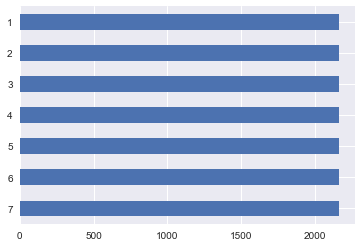

In [14]:
train_labels.value_counts().plot(kind='barh')
train_labels.value_counts()

<a id='identify-the-train-features'/>

### Identify the train features

In the train dataset, there are 15,120 observations with 54 features. 

In [12]:
print(train_data.shape)
train_data.columns

(15120, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In the test dataset, there are 565,892 observations which includes the 54 features found in the train dataset. In other words, we have validated that the train dataset is a good dataset to use as it shares the same cartographic information as the test dataset.

In [15]:
print(test.shape)
test.columns

(565892, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

Looking at the features, it is interesting to note that we do not see longitude and latitude values, which means we cannot validate the cartographic information to the actual geographic location. The 54 features are summarized in the following table below:

| Name                               | Measurement     | Description                                               |
| ----------------------------------:| ---------------:| ---------------------------------------------------------:|
| Elevation                          | meters          | Height above sea level                                    |
| Aspect                             | degrees azimuth | Compass direction that a slope faces<br/>0: North, 90: East, 180: South, 270: West<br/>Potential influence on temperature and soil | 
| Slope                              | degrees         | Degree of incline of a surface<br/>In other words, maximum rate of change of elevation<br/>Has gradient and aspect as components                                                     | 
| Horizontal_Distance_To_Hydrology   | meters          | Horizontal Distance to the nearest surface water features | 
| Vertical_Distance_To_Hydrology     | meters          | Vertical Distance to the nearest surface water features   | 
| Horizontal_Distance_To_Roadways    | meters          | Horizontal distance to the nearest roadway                | 
| Horizontal_Distance_To_Fire_Points | meters          | Horizontal distance to the nearest wildfire ignition points | 
| Hillshade_9am                      | 0 (dark) to 255 (light) | Hillshade index at 9 AM, summer solstice | 
| Hillshade_Noon                     | 0 (dark) to 255 (light) | Hillshade index at 12 PM, summer solstice | 
| Hillshade_3pm                      | 0 (dark) to 255 (light) | Hillshade index at 3 PM, summer solstice | 
| Wilderness_Area (4 binary columns) | 0 (absent) or 1 (present) | Wilderness area designation<br/>1: Rawah, 2: Neota, 3: Comanche, 4: Cache la Poudre | 
| Soil_Type (40 binary columns)      | 0 (absent) or 1 (present) | Soil type designation |



<a id='feature-engineering'/>

## Feature Engineering


<a id='models'/>

## Models


In [ ]:
# --------------------------------------------------------------------------------
# Base Case
# --------------------------------------------------------------------------------

# 1. Logistic Regression
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg')
lr.fit(s_train_data, s_train_labels)
accuracies = []
for i in range(1, 10):
    pred_dev_labels = lr.predict(s_dev_data)
    accuracies.append(accuracy_score(s_dev_labels, pred_dev_labels))
mean_accuracies = sum(accuracies)/len(accuracies)
output_bc[0] = mean_accuracies
mean_accuracies


In [ ]:
# --------------------------------------------------------------------------------
# Base Case with Feature Engineering
# --------------------------------------------------------------------------------


<a id='ensemble-models'/>

## Ensemble Models